# Modeling of AFWA dust emission (dust_opt=3) over the Middle East on 24 June 2016

# Dust_emission_simulator
Mimicking WRF-Chem's v4.2 dust emissions (dust_opt=11 GOCART and dust_opt=13 AFWA) with MOSAIC aerosols.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/saneku/Dust_emission_simulator/afwa_python.ipynb)

In [2]:
#https://ldas.gsfc.nasa.gov/gldas/soils

from utils import *
import netCDF4 as nc
import numpy as np
from matplotlib import pyplot as plt
import os

from afwa_source_dust import afwa_source_dust
from mpl_toolkits.basemap import Basemap
from datetime import datetime

In [3]:
#Load required arrays from wrfoutput file
wrf_out_file = "afwa.nc"
print("Read from: "+wrf_dir + wrf_out_file)
nc_fid = nc.MFDataset(wrf_dir + wrf_out_file)
times =nc_fid.variables['Times'][:]
xland=nc_fid.variables['XLAND'][:]
ustar=nc_fid.variables['UST'][:]
smois = nc_fid.variables["SMOIS"][:, 0, :]  # soil moisture of first level
isltyp = nc_fid.variables["ISLTYP"][:]
snowh = nc_fid.variables["SNOWH"][:]
znt = nc_fid.variables["ZNT"][:]
airden = 1.0 / nc_fid.variables["ALT"][:, 0, :]
erodtot = nc_fid.variables["EROD"][:] # Ginoux DSR, there is a DRI also

massfrac=np.zeros(shape=(3,ny,nx))  #MASSFRAC  Fraction of mass in each of 3 soil classes    (clay, silt, sand)
massfrac[0][:]=nc_fid.variables['CLAYFRAC'][0,:]
massfrac[1][:]=1-(nc_fid.variables['CLAYFRAC'][0,:]+nc_fid.variables['SANDFRAC'][0,:])
massfrac[2][:]=nc_fid.variables['SANDFRAC'][0,:]

#WRF-Chem's flux (kg/m2/sec)
wrf_chems_flux= nc_fid.variables['EDUST1'][:,0]+\
  nc_fid.variables['EDUST2'][:,0]+\
  nc_fid.variables['EDUST3'][:,0]+\
  nc_fid.variables['EDUST4'][:,0]+\
  nc_fid.variables['EDUST5'][:,0]
nc_fid.close()

Read from: ./data/afwa.nc


# emission flux computed by script

/Users/ukhova/Downloads/Dust_emission_simulator/afwa_source_dust.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  gravsm[j,i]=100.0*volsm[j, i]/((1.0-porosity[isltyp[j, i]])*(2.65*(1-massfrac[0,j,i])+2.50*massfrac[0,j,i]))
/var/folders/jk/8sw3mvsn77dbcxpv6nr291x46937hf/T/ipykernel_2740/4006909684.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = m.pcolormesh(x, y, flux, cmap=colmap, norm=ai_norm)


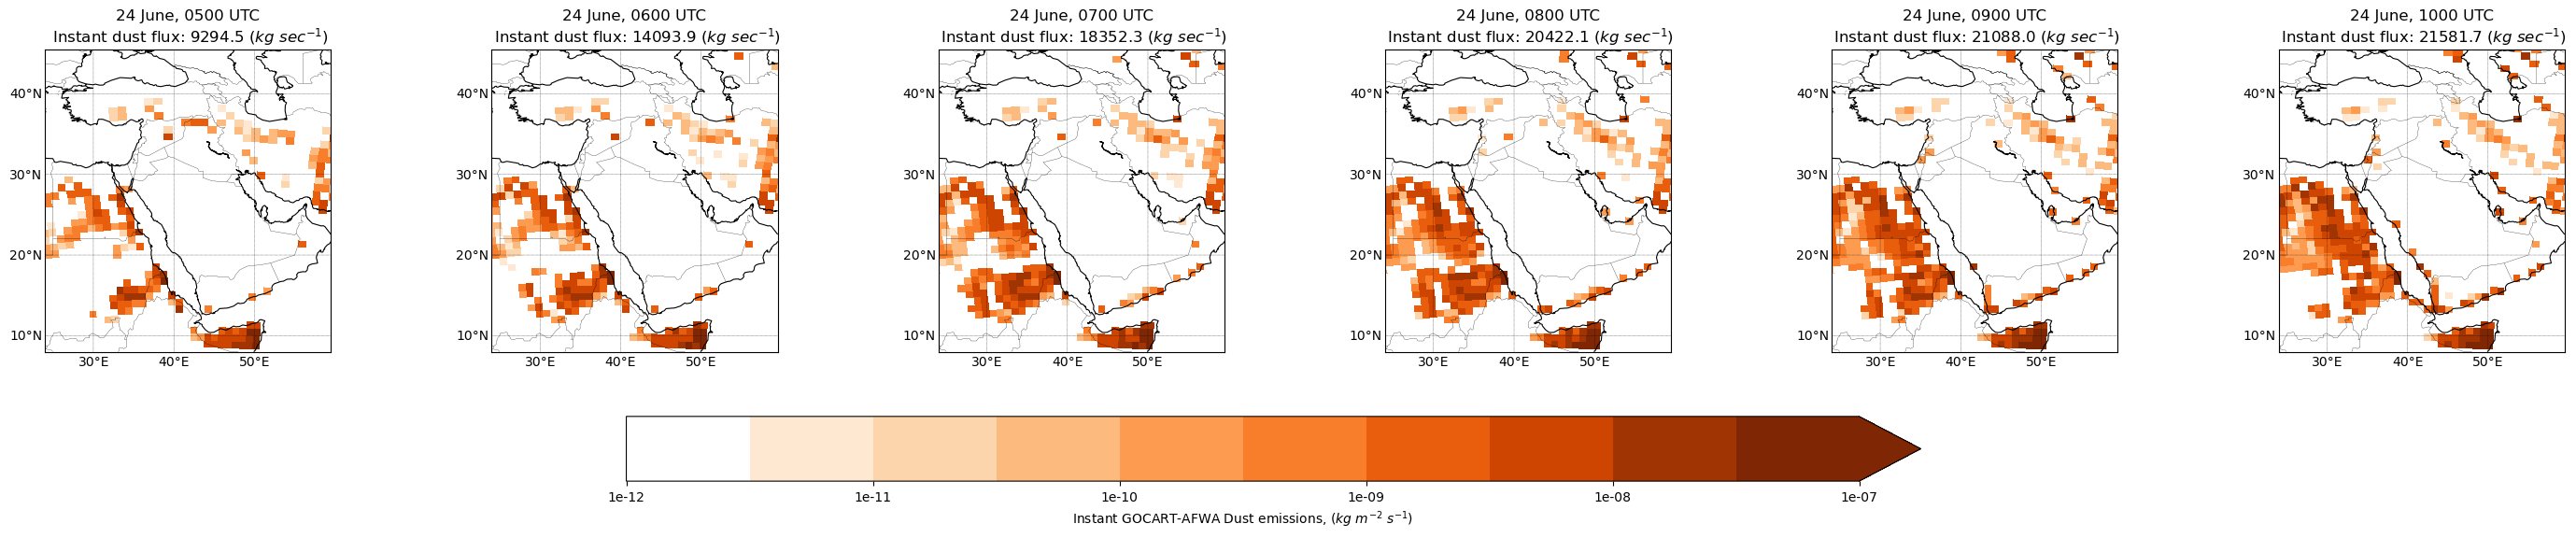

In [4]:
k=len(times)
fig, axes = plt.subplots(1, k,figsize=(k*6,6))
for time_idx in np.arange(0, k):
    flux,u_ts,u_tres=afwa_source_dust(nx,ny,ustar[time_idx], massfrac,erodtot[time_idx], isltyp[time_idx], smois[time_idx], airden[time_idx],xland[time_idx],znt[time_idx],snowh[time_idx])
    #Computed flux (kg/m2/sec)
    total_emission_flux=np.sum(surface*flux)  #(kg/sec)

    m = Basemap(**basemap_params,ax=axes[time_idx])
    x, y = m(xlon, xlat)
    decorateMap(m)

    date_time_obj = datetime.strptime(str(b"".join(times[time_idx])), "b'%Y-%m-%d_%H:%M:%S'")
    axes[time_idx].set_title(date_time_obj.strftime("%d %B, %H%M UTC") + "\n Instant dust flux: " + "{:0.1f}".format(total_emission_flux) + " ($kg\ sec^{-1}$)")

    cs = m.pcolormesh(x, y, flux, cmap=colmap, norm=ai_norm)
    
cbar = fig.colorbar(cs,ax=axes.ravel().tolist(),orientation="horizontal",extend='max',format='%.0e')
cbar.set_label('Instant GOCART-AFWA Dust emissions, '+units)
#plt.savefig("afwa_inst_flux.png",bbox_inches="tight")
plt.show()

# emission flux computed by WRF-Chem

/var/folders/jk/8sw3mvsn77dbcxpv6nr291x46937hf/T/ipykernel_2740/3331053218.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = m.pcolormesh(x, y, wrf_chems_flux[time_idx], cmap=colmap, norm=ai_norm)


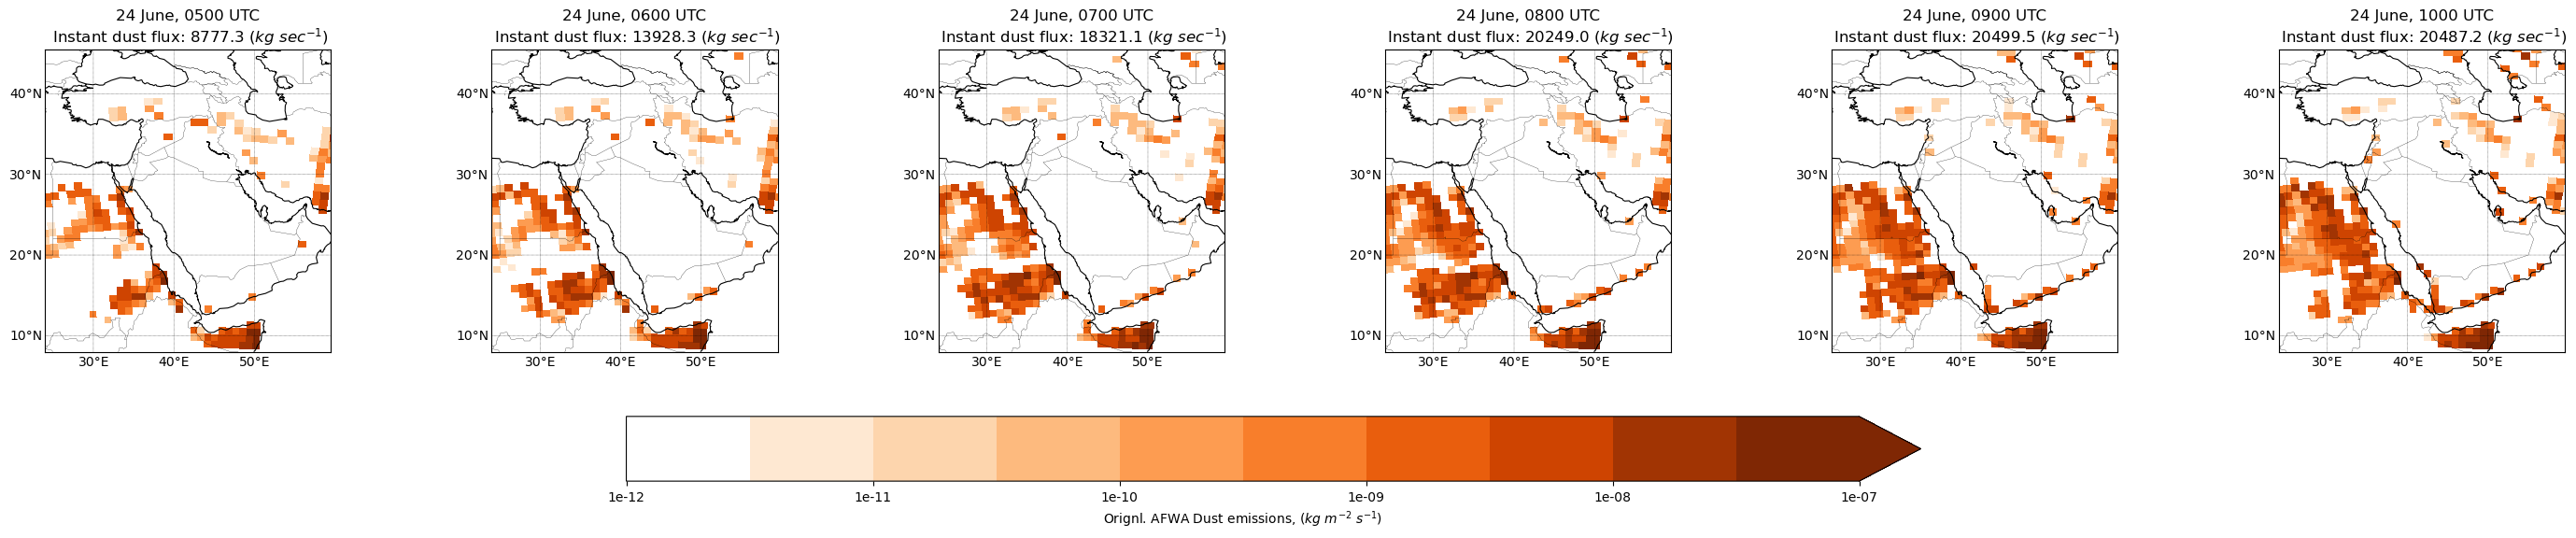

In [5]:
fig, axes = plt.subplots(1, k,figsize=(k*6,6))
for time_idx in np.arange(0, k):
    #because emissions are accumulated here (cumulative, kg/m2)
    #make them average (during one hour) flux
    #flux=(emissions-prev_emissions)/3600.0 # (kg/m2/sec) it will be a little different from what calculated in gocart_python.py

    total_emission_flux=np.sum(surface*wrf_chems_flux[time_idx]) #(kg/sec)

    m = Basemap(**basemap_params,ax=axes[time_idx])
    x, y = m(xlon,xlat)
    decorateMap(m)

    date_time_obj = datetime.strptime(str(b"".join(times[time_idx])), "b'%Y-%m-%d_%H:%M:%S'")
    axes[time_idx].set_title(date_time_obj.strftime("%d %B, %H%M UTC")+"\n Instant dust flux: "+"{:0.1f}".format(total_emission_flux)+" ($kg\ sec^{-1}$)")

    cs = m.pcolormesh(x, y, wrf_chems_flux[time_idx], cmap=colmap, norm=ai_norm)


cbar = fig.colorbar(cs,ax=axes.ravel().tolist(),orientation="horizontal",extend='max',format='%.0e')
cbar.set_label('Orignl. AFWA Dust emissions, '+units)
plt.show()
#plt.savefig("afwa_ornlg_inst_flux.png",bbox_inches="tight",dpi=300)